In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates
from datetime import datetime, time ,date ,timedelta
from dateutil.relativedelta import relativedelta
import seaborn as sns
pd.options.mode.chained_assignment = None

In [2]:
import warnings
warnings.filterwarnings("ignore")

<h1> Functions </h1>

<h3> Fonctions générales </h3>

In [3]:
def floatise (df, list_columns_to_floatise):
    for i in list_columns_to_floatise:
        df[i] = df[i].apply(lambda x: float(x.replace(',','.')))
    return (df)

In [4]:
def intise (df, list_columns_to_floatise):
    for i in list_columns_to_floatise:
        df[i] = df[i].astype(int)
    return (df)

In [5]:
def flatten (table):
    if type(table.columns)==pd.MultiIndex:
        columns_to_look = [name_tmp for name_tmp in table.columns]

        columns_df = [ str(t[0])+'_'+str(t[1]) for t in columns_to_look]
        columns_df.insert(0,table.index.name)

        df = pd.DataFrame(columns = columns_df)

        index = 0
        for i in table.index:
            row = [table[r][i] for r in columns_to_look]
            row.insert(0,i)
            df.loc[index] = row
            index = index + 1
        return(df)
    else :
        table = pd.DataFrame(table)
        table.reset_index(level=0, inplace=True)
        return table

In [6]:
def flatten_soft(dataframe):
    res = pd.DataFrame()
    res[dataframe.index.name] = dataframe.index
    for col in dataframe.columns:
        name_tmp=""
        for i in range(len(dataframe.columns[0])):
            name_tmp = name_tmp +'_'+str(col[i])
        res[str(name_tmp)] = dataframe[col].values
    return res

<h3> Fonctions particulières </h3>

In [7]:
def cohort_attribution (x):
    if (x<2017):
        return 2016
    else :
        return x

<h1> Dataset creation </h1>

<h3> Import de la data </h3>

In [10]:
src_root = os.getcwd()
print(src_root)

C:\Users\UgoMANTEL\Work\Github\Vertbaudet_2021\src\notebooks


- Préparation des colonnes:

In [11]:
col_names = ['AUFTRNR','KDNR','ARTNRERF','WTR','ARTGRERF','DATERF','PREISERF','PREIS','EKP','PREISNET','RABATT','RABATTSATZ',
             'MENGE','MENGERET','DEPARTEMENT','CAUFTRAGSPOS','MWST','MWSTRABATT','ANZKINDER','ANLAGEDAT',
             'DATAUFTRAG1','STRASSE','PLZ','ORT','BUNDESLAND','CLAND','CWERBESP','DATWERBESP','CLIEFERSP','DATLIEFERSP',
             'CADRESSSP','DATADRESSSP','UMSATZ1','DATLETZTAUFTR','UMSLETZTAUFTR','ANZKATLETZTAUFTR','WKOSTLETZTAUFTR',
             'DBKDNR','WKOSTENKUM','UMSATZKUM','UMSATZKUMTEL','UMSATZKUMFAX','UMSATZKUMWEB','UMSATZLIEFKUM','RUECKSTAUFTR',
             'ANZAUFTR','REFPRES','REFSTK','CODDOC','PLANEKP','RAYON','FAMILLE','DEPART','CODMARQ','ARTGROESSE','DATAUFTRAG',
             'DATERFASSUNG','DATVERARB','GUTSCHEINWERT']

In [12]:
dict_department = {'B':'BEBE','N':'PAP FILLE','U':'PAP GARCON','D':'CHAUSSURE','F':'FEMME',
'T':'TEXTILE HOME','P':'PUERICULTURE','W':'NON PAP ENFANT','K':'DECO','M':'CHAMBRE ET LITERIE','R':'JOUETS'}

<h3> Constitution du dataset </h3>

- Définition des répertoires :

In [13]:
repertoire = "C:/Users/UgoMANTEL/Work/Github/Vertbaudet_2021/data/1. Germany"
output_rep = "C:/Users/UgoMANTEL/eleven/Engagements - Vertbaudet/5. Analyses/3. Outputs python"
backup_rep = "C:/Users/UgoMANTEL/Work/Github/Vertbaudet_2021/data/4. Back-up"

- Choix des options

In [14]:
import_data = True

<h4> Création de la donnée: </h4> 

In [15]:
net_demand = True

In [16]:
if import_data==False:
    df = pd.DataFrame()
    for file in os.listdir(repertoire):
        file_name_tmp = os.path.join(repertoire,file)
        df_tmp = pd.read_csv(file_name_tmp,sep=",",encoding= "unicode_escape", usecols=col_names)

        df_tmp = df_tmp.loc[df_tmp.CAUFTRAGSPOS!='$null$']
        df_tmp.CAUFTRAGSPOS = df_tmp.CAUFTRAGSPOS.astype(int)
        df_tmp = df_tmp.loc[df_tmp.CAUFTRAGSPOS <= 7]

        ################### CONVERSION DES CHAMPS ###################
        df_tmp['DATERF'] = pd.to_datetime(df_tmp.DATERF)
        df_tmp['DATAUFTRAG1'] = pd.to_datetime(df_tmp.DATAUFTRAG1)
        df_tmp.DEPARTEMENT = df_tmp.DEPARTEMENT.map(dict_department) 

        ################### CREATION DES CHAMPS ###################
        df_tmp['TOT_SALES'] = (df_tmp.PREIS - df_tmp.RABATT)*(df_tmp.MENGE - df_tmp.MENGERET)
        df_tmp['NET_DEMAND'] = (df_tmp.PREIS - df_tmp.RABATT) * df_tmp.MENGE
        df_tmp['GROSS_DEMAND'] = df_tmp.PREIS * df_tmp.MENGE
        df_tmp['YEAR_FIRST_ORDER'] = df_tmp.DATAUFTRAG1.dt.year
        df_tmp['YEAR_ORDER'] = df_tmp.DATERF.dt.year
        df_tmp['COHORT'] = df_tmp.YEAR_FIRST_ORDER.apply(lambda x: cohort_attribution(x))
        df_tmp['MONTH_RECRUITMENT'] = df_tmp.DATAUFTRAG1.dt.month
        df_tmp['ID_ORDER'] = df_tmp.AUFTRNR.astype(str) + '_'+ df_tmp.KDNR.astype(str)

        if net_demand:
            cat_order =  df_tmp.groupby(['ID_ORDER','DEPARTEMENT']).agg({'NET_DEMAND':sum}).reset_index().sort_values(by='NET_DEMAND',
                                                                                                              ascending=False)
        else:
            cat_order =  df_tmp.groupby(['ID_ORDER','DEPARTEMENT']).agg({'TOT_SALES':sum}).reset_index().sort_values(by='TOT_SALES',
                                                                                                              ascending=False)
        cat_order = cat_order.drop_duplicates(subset=['ID_ORDER'],keep='first')
        cat_order.columns = ['ID_ORDER','DEPARTEMENT_CMD','NET_DEMAND']
        df_tmp = pd.merge(df_tmp,cat_order[['ID_ORDER','DEPARTEMENT_CMD']], on='ID_ORDER', how='left', suffixes=(False,False))

        df_tmp = df_tmp[['DATERF','DATAUFTRAG1','DEPARTEMENT','TOT_SALES','NET_DEMAND','GROSS_DEMAND',
                        'YEAR_FIRST_ORDER','YEAR_ORDER','COHORT','MONTH_RECRUITMENT','ID_ORDER','KDNR','ARTNRERF',
                         'DEPARTEMENT_CMD','RABATT','RABATTSATZ','PREIS','ANZKINDER','ARTGRERF','ARTGROESSE']]
        df = pd.concat([df,df_tmp])
        del(df_tmp)

    ################### CREATION DE CHAMPS ###################
    ################### UNIVERS RECRUTEMENT
    cat_rec = df.sort_values(by='DATERF',ascending=True).drop_duplicates(subset='KDNR', keep='first', inplace=False)[['KDNR','DEPARTEMENT_CMD']] 
    cat_rec.columns = ['KDNR','DEPARTEMENT_FIRST']
    df = pd.merge(df,cat_rec,on='KDNR',how='left',suffixes=(False,False))

    ################### DATE POUR LTV 12/24 MOIS
    df['DATAUFTRAG1_12MONTH'] = df['DATAUFTRAG1']+ timedelta(days=365)
    df['DATAUFTRAG1_24MONTH'] = df['DATAUFTRAG1']+ timedelta(days=730)

- Ajout du numcmde var 38 :

In [17]:
if import_data==False:
    df_numcde = pd.read_csv("C:/Users/UgoMANTEL/Work/Github/Vertbaudet_2021/data/3. Other/20211001_NUM_CMD_CANAL_GER.csv",sep=",",encoding= "unicode_escape")
    df_numcde['ID_ORDER'] = df_numcde.AUFTNR.astype(str) + '_'+ df_numcde.KDNR.astype(str)
    df = pd.merge(df,df_numcde[['ID_ORDER','BELEGSTAPELNR']],on='ID_ORDER',how='left',suffixes=(False,False))
    del(df_numcde)

In [18]:
if import_data==False:
    file_name = 'Raw_data_LTV_Germany_new.csv'
    df.to_csv(os.path.join(backup_rep,file_name),sep=";")

<h4> Import de la donnée: </h4>

In [19]:
if import_data:
    df = pd.read_csv(os.path.join(backup_rep,'Raw_data_LTV_Germany.csv'),sep=";")
    df.drop(columns=['Unnamed: 0'],inplace=True)
    
    ########## Conversion des champs
    df['DATERF'] = pd.to_datetime(df.DATERF)
    df['DATAUFTRAG1'] = pd.to_datetime(df.DATAUFTRAG1)
    df['DATAUFTRAG1_12MONTH'] = pd.to_datetime(df.DATAUFTRAG1_12MONTH)
    df['DATAUFTRAG1_24MONTH'] = pd.to_datetime(df.DATAUFTRAG1_24MONTH)

<h4> Nouvelles colonnes: </h4>

- Séniorité:

In [20]:
df['SENIORITY'] = (datetime.now() - df['DATAUFTRAG1']).dt.days

- Date 36 mois:

In [21]:
df['DATAUFTRAG1_36MONTH'] = df['DATAUFTRAG1']+ timedelta(days=1080)

- Order majoritaire:

In [22]:
order_maj = df.groupby(['KDNR','DEPARTEMENT']).agg({'NET_DEMAND':sum}).reset_index().sort_values(by='NET_DEMAND',ascending=False)
order_maj = order_maj.drop_duplicates(subset=['KDNR'],keep='first')
order_maj.columns = ['KDNR','DEPARTEMENT_MAJORITAIRE','NET_DEMAND']
df = pd.merge(df,order_maj[['KDNR','DEPARTEMENT_MAJORITAIRE']],on='KDNR',how='left',suffixes=(False,False))

<h1> LTV 12/24/36 mois par cohortes </h1>

In [23]:
print(str(len(df.loc[(df.YEAR_FIRST_ORDER>=2017)].KDNR.unique())))
print('360: '+str(len(df.loc[(df.SENIORITY > 360) & (df.YEAR_FIRST_ORDER>=2017)].KDNR.unique())))
print('730: '+str(len(df.loc[(df.SENIORITY > 730) & (df.YEAR_FIRST_ORDER>=2017)].KDNR.unique())))
print('1080: '+str(len(df.loc[(df.SENIORITY > 1080) & (df.YEAR_FIRST_ORDER>=2017)].KDNR.unique())))

975384
360: 672198
730: 453476
1080: 287759


- 12 mois:

In [24]:
df_ltv_12 = df.loc[(df.DATERF<=df.DATAUFTRAG1_12MONTH) & (df.KDNR!=26388862) & (df.YEAR_FIRST_ORDER>=2017) & (df.SENIORITY > 365)]

In [25]:
nb_order_ltv_12 = flatten(df_ltv_12.groupby(['KDNR']).agg({'NET_DEMAND': sum, 'ID_ORDER':pd.Series.nunique}))
nb_order_ltv_12.columns = ['KDNR','LTV_12','NB_ORDER']
df_ltv_12 = pd.merge(df_ltv_12,nb_order_ltv_12, on='KDNR',how='left',suffixes=(False,False))
df_ltv_12 = df_ltv_12.loc[df_ltv_12.LTV_12>=0]

In [26]:
df_ltv_12.drop_duplicates(subset='KDNR', keep='first').LTV_12.mean()

137.33529406733714

In [27]:
df_ltv_12.drop_duplicates(subset='KDNR', keep='first').groupby(['COHORT']).agg({'LTV_12':'mean'})

,LTV_12
COHORT,
2017,154.790806
2018,133.763463
2019,123.500536
2020,140.885956


- 24 mois:

In [28]:
df_ltv_24 = df.loc[(df.DATERF<=df.DATAUFTRAG1_24MONTH) & (df.KDNR!=26388862) & (df.YEAR_FIRST_ORDER>=2017)& (df.SENIORITY > 730)]

In [29]:
nb_order_ltv_24 = flatten(df_ltv_24.groupby(['KDNR']).agg({'NET_DEMAND': sum, 'ID_ORDER':pd.Series.nunique}))
nb_order_ltv_24.columns = ['KDNR','LTV_24','NB_ORDER']
df_ltv_24 = pd.merge(df_ltv_24,nb_order_ltv_24, on='KDNR',how='left',suffixes=(False,False))
df_ltv_24 = df_ltv_24.loc[df_ltv_24.LTV_24>=0]

- 36 mois:

In [30]:
df_ltv_36 = df.loc[(df.DATERF <= df.DATAUFTRAG1_36MONTH) & (df.KDNR!=26388862) & (df.YEAR_FIRST_ORDER>=2017)& (df.SENIORITY > 1080)]

In [31]:
nb_order_ltv_36 = flatten(df_ltv_36.groupby(['KDNR']).agg({'NET_DEMAND': sum, 'ID_ORDER':pd.Series.nunique}))
nb_order_ltv_36.columns = ['KDNR','LTV_36','NB_ORDER']
df_ltv_36 = pd.merge(df_ltv_36,nb_order_ltv_36, on='KDNR',how='left',suffixes=(False,False))
df_ltv_36 = df_ltv_36.loc[df_ltv_36.LTV_36>=0]

<h3> Selon mois de recrutement </h3>

In [32]:
per_year = False

<h4> Première commande: </h4>

In [35]:
first_price_per_month = df_ltv_12.groupby(['KDNR','ID_ORDER']).agg({'NET_DEMAND' : 'sum', 'MONTH_RECRUITMENT':'last','DATERF':'first'})
first_price_per_month.reset_index(inplace=True)
first_price_per_month

,KDNR,ID_ORDER,NET_DEMAND,MONTH_RECRUITMENT,DATERF
0,8956580,1_8956580,129.98,11,2019-11-16
1,11918894,1_11918894,59.98,5,2017-05-28
2,12107245,1_12107245,111.13,11,2018-11-21
3,25000120,1_25000120,72.34,1,2017-01-01
4,25000120,2_25000120,87.96,1,2017-03-28
...,...,...,...,...,...
1086959,33439290,1_33439290,82.82,10,2020-10-17
1086960,33439290,2_33439290,38.98,10,2020-12-22
1086961,33439290,3_33439290,25.63,10,2021-01-29
1086962,33439304,1_33439304,97.74,10,2020-10-17


In [36]:
first_price_per_month = first_price_per_month.sort_values(by='DATERF',ascending=True).drop_duplicates(subset='KDNR', keep='first',inplace=False)

In [37]:
first_price_per_month = first_price_per_month.groupby('MONTH_RECRUITMENT').agg({'NET_DEMAND':'mean'})
first_price_per_month.to_csv(os.path.join(output_rep,'Price_1st_order_per_month_GER.csv'),sep=";")
first_price_per_month

,NET_DEMAND
MONTH_RECRUITMENT,
1,75.818998
2,91.403056
3,94.394783
4,91.956650
5,90.644442
6,84.709342
7,76.445387
8,85.987261
9,89.760402


<h4> 12 mois: </h4>

In [38]:
if per_year:
    resltv_month_recrut = df_ltv_12.drop_duplicates(subset='KDNR', keep='first').groupby(['COHORT','MONTH_RECRUITMENT']).agg({'LTV_12': 'mean'})
    resltv_month_recrut = flatten_soft(resltv_month_recrut.unstack('COHORT',fill_value=0))
    file_name_ltv_month = 'LTV12_per_month_DN_GER_perCohort.csv'
else:
    resltv_month_recrut = flatten(df_ltv_12.drop_duplicates(subset='KDNR', keep='first').groupby(['MONTH_RECRUITMENT']).agg({'LTV_12': 'mean'}))
    file_name_ltv_month = 'LTV12_per_month_DN_GER.csv'
resltv_month_recrut

,MONTH_RECRUITMENT,LTV_12
0,1,128.297371
1,2,147.458983
2,3,151.533236
3,4,148.092601
4,5,144.741457
5,6,142.367808
6,7,128.325485
7,8,138.536753
8,9,144.959254
9,10,138.067189


In [39]:
resltv_month_recrut.to_csv(os.path.join(output_rep,file_name_ltv_month),sep=";")

<h4>24 mois:</h4>

In [40]:
if per_year:
    resltv_month_recrut = df_ltv_24.drop_duplicates(subset='KDNR', keep='first').groupby(['COHORT','MONTH_RECRUITMENT']).agg({'LTV_24': 'mean'})
    resltv_month_recrut = flatten_soft(resltv_month_recrut.unstack('COHORT',fill_value=0))
    
else :
    resltv_month_recrut = flatten(df_ltv_24.drop_duplicates(subset='KDNR', keep='first').groupby(['MONTH_RECRUITMENT']).agg({'LTV_24': 'mean'}))
resltv_month_recrut

,MONTH_RECRUITMENT,LTV_24
0,1,162.434171
1,2,189.148641
2,3,189.309705
3,4,177.056674
4,5,168.626349
5,6,165.996226
6,7,155.748257
7,8,174.562950
8,9,181.272312
9,10,172.404862


In [41]:
file_name_ltv_month_24 = 'LTV24_per_month_DN_GER.csv'
resltv_month_recrut.to_csv(os.path.join(output_rep,file_name_ltv_month_24),sep=";")

<h4> 36 mois: </h4>

In [42]:
if per_year:
    resltv_month_recrut = df_ltv_36.drop_duplicates(subset='KDNR', keep='first').groupby(['COHORT','MONTH_RECRUITMENT']).agg({'LTV_36': 'mean'})
    resltv_month_recrut = flatten_soft(resltv_month_recrut.unstack('COHORT',fill_value=0))
    file_name_ltv_month = 'LTV36_per_month_DN_GER_perCohort.csv'
else:
    resltv_month_recrut = flatten(df_ltv_36.drop_duplicates(subset='KDNR', keep='first').groupby(['MONTH_RECRUITMENT']).agg({'LTV_36': 'mean'}))
    file_name_ltv_month = 'LTV36_per_month_DN_GER.csv'
resltv_month_recrut

,MONTH_RECRUITMENT,LTV_36
0,1,202.393923
1,2,233.027003
2,3,225.179378
3,4,213.482104
4,5,197.944901
5,6,197.358722
6,7,188.076963
7,8,212.884050
8,9,215.869903
9,10,205.401530


In [43]:
resltv_month_recrut.to_csv(os.path.join(output_rep,file_name_ltv_month),sep=";")

- Tcheck de cohérence:

In [117]:
# flatten(df_ltv_12.loc[(df_ltv_12.COHORT==2017) &(df_ltv_12.MONTH_RECRUITMENT==6)].groupby(['KDNR']).agg({'LTV_12': 'last'})).sort_values(by='LTV_12',ascending=False)

In [118]:
# df.loc[df.KDNR==26388862].TOT_SALES.sum()

- Ajout du volume de recrutement:

In [15]:
vol_recrut = flatten(df.loc[(df.COHORT>=2017) & (df.COHORT<2021)].groupby(['MONTH_RECRUITMENT']).agg({'KDNR': pd.Series.nunique}))

In [16]:
vol_recrut.to_csv(os.path.join(output_rep,'volume_recruitment_per_month_GER.csv'),sep=";")

<h3> Selon univers de recrutement </h3>

<h4> 12 mois:</h4>

In [28]:
resltv_univ_recrut = df_ltv_12.drop_duplicates(subset='KDNR', keep='first').groupby(['DEPARTEMENT_FIRST']).agg({'LTV_12': 'mean'})
resltv_univ_recrut

,LTV_12
DEPARTEMENT_FIRST,
BEBE,131.646784
CHAMBRE ET LITERIE,187.681153
CHAUSSURE,119.017345
DECO,120.454703
FEMME,200.766088
JOUETS,74.237045
NON PAP ENFANT,73.418782
PAP FILLE,144.018395
PAP GARCON,132.326453


In [19]:
# resnborder_univ_recrut = df_ltv_12.groupby(['COHORT','DEPARTEMENT_FIRST']).agg({'NB_ORDER': 'mean'})

# resnborder_univ_recrut = flatten_soft(resnborder_univ_recrut.unstack('COHORT',fill_value=0))
# resnborder_univ_recrut

In [45]:
file_name_ltv_univ = 'LTV12_per_univ_GER.csv'
resltv_univ_recrut.to_csv(os.path.join(output_rep,file_name_ltv_univ),sep=";")

# file_name_nborder_univ_12 = 'NBorder_per_univ_12.csv'
# resnborder_univ_recrut.to_csv(os.path.join(output_rep,file_name_nborder_univ_12),sep=";")

<h4> 24 mois: </h4>

In [29]:
per_year = False

In [30]:
if per_year :
    resltv_univ_recrut = df_ltv_24.drop_duplicates(subset='KDNR', keep='first').groupby(['COHORT','DEPARTEMENT_FIRST']).agg({'LTV_24': 'mean'})
    resltv_univ_recrut = flatten_soft(resltv_univ_recrut.unstack('COHORT',fill_value=0))
    
else:
    resltv_univ_recrut = flatten(df_ltv_24.drop_duplicates(subset='KDNR', keep='first').groupby(['DEPARTEMENT_FIRST']).agg({'LTV_24': 'mean'}))
    
resltv_univ_recrut

,DEPARTEMENT_FIRST,LTV_24
0,BEBE,167.764484
1,CHAMBRE ET LITERIE,214.575169
2,CHAUSSURE,150.160977
3,DECO,154.246817
4,FEMME,231.072903
5,JOUETS,81.640930
6,NON PAP ENFANT,95.308748
7,PAP FILLE,176.557210
8,PAP GARCON,163.817561
9,PUERICULTURE,107.351511


In [132]:
# resnborder_univ_recrut = df_ltv_24.groupby(['COHORT','DEPARTEMENT_FIRST']).agg({'NB_ORDER': 'mean'})

# resnborder_univ_recrut = flatten_soft(resnborder_univ_recrut.unstack('COHORT',fill_value=0))
# resnborder_univ_recrut

,DEPARTEMENT_FIRST,_NB_ORDER_2017,_NB_ORDER_2018,_NB_ORDER_2019,_NB_ORDER_2020,_NB_ORDER_2021
0,BEBE,5.156239,4.582646,4.644468,3.964485,2.409886
1,CHAMBRE ET LITERIE,4.255945,3.694553,3.829816,3.037413,1.909553
2,CHAUSSURE,4.251203,3.556022,4.207344,2.948122,1.745365
3,DECO,4.547955,4.167887,4.048865,3.277416,1.958501
4,FEMME,4.096965,3.716640,4.196590,3.584811,2.230489
5,JOUETS,4.130995,3.187672,3.368866,2.653540,1.862670
6,NON PAP ENFANT,4.084211,3.550785,3.679548,2.758776,1.767003
7,PAP FILLE,4.079427,3.847284,3.936201,3.232288,1.893169
8,PAP GARCON,3.828874,3.709215,3.765333,2.901899,1.775088
9,PUERICULTURE,4.051365,3.842078,4.384791,4.640293,2.136888


In [48]:
file_name_ltv_univ_24 = 'LTV24_per_univ_global_GER.csv'
resltv_univ_recrut.to_csv(os.path.join(output_rep,file_name_ltv_univ_24),sep=";")

# file_name_nborder_univ_24 = 'NBorder_per_univ_GER.csv'
# resnborder_univ_recrut.to_csv(os.path.join(output_rep,file_name_nborder_univ_24),sep=";")

<h4> 36 mois: </h4>

In [31]:
resltv_univ_recrut = flatten(df_ltv_36.drop_duplicates(subset='KDNR', keep='first').groupby(['DEPARTEMENT_FIRST']).agg({'LTV_36': 'mean'}))
file_name_ltv_univ_36 = 'LTV36_per_univ_global_GER.csv'
# resltv_univ_recrut.to_csv(os.path.join(output_rep,file_name_ltv_univ_36),sep=";")
resltv_univ_recrut

,DEPARTEMENT_FIRST,LTV_36
0,BEBE,210.378049
1,CHAMBRE ET LITERIE,250.268609
2,CHAUSSURE,184.256213
3,DECO,192.536781
4,FEMME,266.232957
5,JOUETS,105.820922
6,NON PAP ENFANT,123.502290
7,PAP FILLE,210.058549
8,PAP GARCON,194.092208
9,PUERICULTURE,125.703334


<h4> Prix par univers:</h4>

In [136]:
price_universe = flatten(df.groupby(['DEPARTEMENT']).agg({'PREIS': 'mean'}))

In [137]:
price_universe

,DEPARTEMENT,PREIS
0,BEBE,15.544295
1,CHAMBRE ET LITERIE,86.761654
2,CHAUSSURE,29.933542
3,DECO,27.988024
4,FEMME,25.684211
5,JOUETS,23.746056
6,NON PAP ENFANT,12.915995
7,PAP FILLE,16.580191
8,PAP GARCON,16.191871
9,PUERICULTURE,26.931690


<h4> Prix première commande par univers:</h4>

In [28]:
first_price_per_univ = df_ltv_12.groupby(['KDNR','ID_ORDER']).agg({'NET_DEMAND' : 'sum', 'DEPARTEMENT_FIRST':'last','DATERF':'first'})
first_price_per_univ.reset_index(inplace=True)
first_price_per_univ = first_price_per_univ.sort_values(by='DATERF',ascending=True).drop_duplicates(subset='KDNR', keep='first',inplace=False)
first_price_per_univ

In [29]:
res_first_price_per_univ = first_price_per_univ.groupby('DEPARTEMENT_FIRST').agg({'NET_DEMAND':'mean'})
res_first_price_per_univ.to_csv(os.path.join(output_rep,'Price_1st_order_per_univ_GER.csv'),sep=";")
res_first_price_per_univ

,NET_DEMAND
DEPARTEMENT_FIRST,
BEBE,64.846543
CHAMBRE ET LITERIE,148.905361
CHAUSSURE,86.175648
DECO,72.119263
FEMME,124.975554
JOUETS,53.935099
NON PAP ENFANT,46.234522
PAP FILLE,85.592439
PAP GARCON,80.773918


<h3> Selon univers majoritaire </h3>

<h4> Prix première commande par univers:</h4>

In [44]:
first_price_per_univ = df_ltv_12.groupby(['KDNR','ID_ORDER']).agg({'NET_DEMAND' : 'sum', 'DEPARTEMENT_MAJORITAIRE':'last','DATERF':'first'})
first_price_per_univ.reset_index(inplace=True)
first_price_per_univ = first_price_per_univ.sort_values(by='DATERF',ascending=True).drop_duplicates(subset='KDNR', keep='first',inplace=False)
first_price_per_univ

,KDNR,ID_ORDER,NET_DEMAND,DEPARTEMENT_MAJORITAIRE,DATERF
3419,25397670,1_25397670,76.04,FEMME,2017-01-01
3973,25400876,1_25400876,33.97,DECO,2017-01-01
3971,25400841,1_25400841,31.99,CHAMBRE ET LITERIE,2017-01-01
3970,25400833,1_25400833,114.43,FEMME,2017-01-01
3968,25400825,1_25400825,259.15,CHAMBRE ET LITERIE,2017-01-01
...,...,...,...,...,...
1032900,33066695,2_33066695,84.97,PAP FILLE,2021-08-24
1044382,33143872,6_33143872,15.29,PAP FILLE,2021-08-27
895180,32146656,3_32146656,19.99,PAP FILLE,2021-08-27
918161,32313727,2_32313727,125.93,PAP FILLE,2021-09-10


In [45]:
res_first_price_per_univ = first_price_per_univ.groupby('DEPARTEMENT_MAJORITAIRE').agg({'NET_DEMAND':'mean'})
res_first_price_per_univ.to_csv(os.path.join(output_rep,'Price_1st_order_per_univmaj_GER.csv'),sep=";")
res_first_price_per_univ

,NET_DEMAND
DEPARTEMENT_MAJORITAIRE,
BEBE,72.032163
CHAMBRE ET LITERIE,130.367097
CHAUSSURE,73.804721
DECO,74.851926
FEMME,126.706605
JOUETS,49.181630
NON PAP ENFANT,42.004181
PAP FILLE,88.581619
PAP GARCON,82.357509


<h4> 12 mois:</h4>

In [41]:
resltv_univ_recrut = df_ltv_12.drop_duplicates(subset='KDNR', keep='first').groupby(['DEPARTEMENT_MAJORITAIRE']).agg({'LTV_12': 'mean'})
resltv_univ_recrut.to_csv(os.path.join(output_rep,'LTV12_per_univ_maj_GER.csv'),sep=";")
resltv_univ_recrut

,LTV_12
DEPARTEMENT_MAJORITAIRE,
BEBE,142.023772
CHAMBRE ET LITERIE,186.384222
CHAUSSURE,115.567057
DECO,112.400042
FEMME,192.472495
JOUETS,72.285130
NON PAP ENFANT,56.028859
PAP FILLE,153.541763
PAP GARCON,139.198563


<h4> 24 mois:</h4>

In [42]:
resltv_univ_recrut = df_ltv_24.drop_duplicates(subset='KDNR', keep='first').groupby(['DEPARTEMENT_MAJORITAIRE']).agg({'LTV_24': 'mean'})
resltv_univ_recrut.to_csv(os.path.join(output_rep,'LTV24_per_univ_maj_GER.csv'),sep=";")
resltv_univ_recrut

,LTV_24
DEPARTEMENT_MAJORITAIRE,
BEBE,171.877611
CHAMBRE ET LITERIE,220.518663
CHAUSSURE,146.644417
DECO,140.312142
FEMME,215.350749
JOUETS,80.055751
NON PAP ENFANT,65.346731
PAP FILLE,203.050868
PAP GARCON,184.792307


<h4> 36 mois:</h4>

In [43]:
resltv_univ_recrut = df_ltv_36.drop_duplicates(subset='KDNR', keep='first').groupby(['DEPARTEMENT_MAJORITAIRE']).agg({'LTV_36': 'mean'})
resltv_univ_recrut.to_csv(os.path.join(output_rep,'LTV36_per_univ_maj_GER.csv'),sep=";")
resltv_univ_recrut

,LTV_36
DEPARTEMENT_MAJORITAIRE,
BEBE,199.546858
CHAMBRE ET LITERIE,267.669154
CHAUSSURE,179.085548
DECO,171.335372
FEMME,243.921510
JOUETS,103.793003
NON PAP ENFANT,80.364688
PAP FILLE,255.205557
PAP GARCON,231.115150


<h3> Répartition DN par univers d'entrée:</h3>

In [39]:
df['DEP_1ST'] = df.DEPARTEMENT_FIRST.apply(lambda x: str(str(x)+"_1"))
DN_per_1stuniv = df.loc[df.YEAR_FIRST_ORDER>=2017].groupby(['DEP_1ST','DEPARTEMENT']).agg({'NET_DEMAND' : 'sum'})
DN_per_1stuniv = flatten_soft(DN_per_1stuniv.unstack('DEP_1ST',fill_value=0))
DN_per_1stuniv.to_csv(os.path.join(output_rep,'DN_univ_entré_GER.csv'),sep=";")
DN_per_1stuniv

,DEPARTEMENT,_NET_DEMAND_BEBE_1,_NET_DEMAND_CHAMBRE ET LITERIE_1,_NET_DEMAND_CHAUSSURE_1,_NET_DEMAND_DECO_1,_NET_DEMAND_FEMME_1,_NET_DEMAND_JOUETS_1,_NET_DEMAND_NON PAP ENFANT_1,_NET_DEMAND_PAP FILLE_1,_NET_DEMAND_PAP GARCON_1,_NET_DEMAND_PUERICULTURE_1,_NET_DEMAND_TEXTILE HOME_1,_NET_DEMAND_nan_1
0,BEBE,1.452352e+07,6.865588e+05,4.559045e+05,1.683359e+06,4.294263e+06,5.596652e+05,1.544108e+05,7.462371e+05,4.554889e+05,848084.07,1.787164e+06,140.48
1,CHAMBRE ET LITERIE,1.011610e+06,1.293930e+07,2.766230e+05,1.341019e+06,1.050953e+06,2.797821e+05,1.395827e+05,4.791087e+05,2.220599e+05,222958.56,7.239950e+05,59.99
2,CHAUSSURE,8.436951e+05,2.891602e+05,3.391049e+06,4.218062e+05,4.958408e+05,1.026785e+05,1.268792e+05,7.381893e+05,3.759843e+05,121863.76,3.456951e+05,192.95
3,DECO,1.251284e+06,2.028578e+06,2.390047e+05,8.561072e+06,1.485128e+06,3.854051e+05,1.049927e+05,3.882498e+05,1.838343e+05,305643.08,9.209202e+05,163.27
4,FEMME,1.334084e+06,3.985597e+05,2.115037e+05,8.173237e+05,2.042931e+07,1.665742e+05,9.632067e+04,3.864664e+05,2.211218e+05,349230.22,6.258755e+05,572.06
5,JOUETS,8.359817e+05,4.326387e+05,1.171193e+05,7.246573e+05,5.880184e+05,3.597235e+06,5.797919e+04,1.840774e+05,9.922857e+04,209792.58,4.688297e+05,110.92
6,NON PAP ENFANT,8.095783e+05,3.087049e+05,4.675755e+05,4.178116e+05,4.803124e+05,1.128962e+05,1.602664e+06,1.318395e+06,9.218953e+05,89911.16,4.005129e+05,194.28
7,PAP FILLE,2.532137e+06,9.619508e+05,1.609735e+06,1.230237e+06,1.398401e+06,2.915673e+05,8.546034e+05,1.328931e+07,8.866456e+05,229396.50,9.901740e+05,65.57
8,PAP GARCON,1.709723e+06,5.504987e+05,9.627107e+05,7.454860e+05,1.006896e+06,1.808588e+05,6.875889e+05,1.038499e+06,8.219054e+06,171072.70,7.001380e+05,950.34
9,PUERICULTURE,4.237300e+05,1.554075e+05,4.104858e+04,2.753556e+05,4.769429e+05,1.140393e+05,1.799062e+04,5.201272e+04,3.446966e+04,2025664.77,2.570394e+05,39.99


<h1> Evolution dépenses par univers </h1>

- Par année en base:

In [19]:
per_year = False

In [20]:
df_evolution = df.loc[(df.COHORT>=2017)]

df_evolution['TIME_TO_ENTRY'] = (df_evolution.DATERF - df_evolution.DATAUFTRAG1).dt.days
df_evolution['YEAR_TO_ENTRY'] = (df_evolution.TIME_TO_ENTRY // 365)+1
df_evolution = df_evolution.loc[df_evolution.YEAR_TO_ENTRY>0]

if per_year:
    for year in df_evolution.COHORT.unique():
        df_tmp = df_evolution.loc [df_evolution.COHORT == year]
        if net_demand:
            res_evo = df_tmp.groupby(['YEAR_TO_ENTRY','DEPARTEMENT']).agg({'NET_DEMAND': sum})
        else:
            res_evo = df_tmp.groupby(['YEAR_TO_ENTRY','DEPARTEMENT']).agg({'TOT_SALES': sum})
        res_evo = flatten_soft(res_evo.unstack('YEAR_TO_ENTRY',fill_value=0))
        file_name_evo = 'evo_univ'+str(year)+'.csv'
        res_evo.to_csv(os.path.join(output_rep,file_name_evo),sep=";")
else :
    if net_demand:
            res_evo = df_evolution.groupby(['YEAR_TO_ENTRY','DEPARTEMENT']).agg({'NET_DEMAND': sum})
    else:
        res_evo = df_evolution.groupby(['YEAR_TO_ENTRY','DEPARTEMENT']).agg({'TOT_SALES': sum})
    res_evo = flatten_soft(res_evo.unstack('YEAR_TO_ENTRY',fill_value=0))
    file_name_evo = 'evo_univ.csv'
    res_evo.to_csv(os.path.join(output_rep,file_name_evo),sep=";")

In [21]:
df_evolution.loc[df_evolution.YEAR_TO_ENTRY<=0].TOT_SALES.sum()

429198.91000000003

- Par année:

In [51]:
res_univ = df.groupby(['YEAR_ORDER','DEPARTEMENT']).agg({'TOT_SALES': sum})
diff_univ = flatten_soft(res_univ.unstack('YEAR_ORDER',fill_value=0))
file_name_evo = 'univ_per_year.csv'
diff_univ.to_csv(os.path.join(output_rep,file_name_evo),sep=";")

<h1> Sankey par univers d'achat </h1>

In [32]:
zoom = False
zoom_year = 2020

In [33]:
df_sankey = df.loc[(df.COHORT>=2017) & (df.COHORT<2021)]
if zoom:
    df_sankey = df_sankey.loc[df_sankey.COHORT == zoom_year]

- Rajouter numéro de commandes:

In [34]:
nb_order =  flatten(df.groupby(['ID_ORDER']).agg({'KDNR':'last','DATERF':'last'})).sort_values(by='DATERF',ascending=True)
nb_order['ORDER_NUMBER'] = nb_order.groupby(['KDNR']).cumcount()+1
df_sankey = pd.merge(df_sankey,nb_order[['ID_ORDER','ORDER_NUMBER']],on='ID_ORDER',how='left')

- Définir la profondeur :

In [35]:
profondeur_sankey = 3

- Obtenir le graph:

In [36]:
res_final = pd.DataFrame(columns=['OrderInitial','Count','OrderTarget'])

df_sankey_to_graph = df_sankey.loc[df_sankey.ORDER_NUMBER<=profondeur_sankey]
res_sankey = df_sankey_to_graph.groupby(['KDNR','ORDER_NUMBER']).agg({'DEPARTEMENT_CMD':'last'})
res_sankey = flatten_soft(res_sankey.unstack('ORDER_NUMBER',fill_value='CHURN').dropna(how='any'))
res_sankey.columns

for i in range(1, profondeur_sankey):
    dep_n = str('_DEPARTEMENT_CMD_'+str(i))
    dep_n_1 = str('_DEPARTEMENT_CMD_'+str(i+1))
    res_sankey_tmp = res_sankey.groupby([dep_n,dep_n_1]).agg({'KDNR':pd.Series.nunique})
    res_sankey_tmp = flatten(res_sankey_tmp)
    res_sankey_tmp = res_sankey_tmp.reset_index(inplace=False)
    
#     'OrderInitial' = str('Order_'+str(i))
#     'OrderTarget' = str('Order_'+str(i+1))

    res_sankey_tmp.columns = ['OrderTarget','OrderInitial','Count']
    res_sankey_tmp = res_sankey_tmp.loc[(res_sankey_tmp['OrderInitial']!='CHURN')]
    res_sankey_tmp['OrderInitial']= res_sankey_tmp['OrderInitial'].apply(lambda x: str(x+'_'+str(i)))
    res_sankey_tmp['OrderTarget']= res_sankey_tmp['OrderTarget'].apply(lambda x: str(x+'_'+str(i+1)))
    res_sankey_tmp['Count']= res_sankey_tmp['Count'].apply(lambda x: str('['+str(x)+']'))
    res_sankey_tmp = res_sankey_tmp[['OrderInitial','Count','OrderTarget']]
    res_final = pd.concat([res_final,res_sankey_tmp])
    
if zoom:
    res_final.to_csv(os.path.join(output_rep,str('sankey_cohort_'+str(zoom_year)+'_GER.csv')),sep=";")
else:
    res_final.to_csv(os.path.join(output_rep,str('sankey_GER_'+str(profondeur_sankey)+'.csv')),sep=";")

<h1> Sankey par canal</h1>

In [34]:
zoom = False
zoom_year = 2020

In [35]:
df_sankey = df.loc[(df.COHORT>=2017) & (df.COHORT<2021)]
if zoom:
    df_sankey = df_sankey.loc[df_sankey.COHORT == zoom_year]

- Import et création des colonnes:

In [36]:
df_canal = pd.read_csv("C:/Users/UgoMANTEL/Work/Github/Vertbaudet_2021/data/3. Other/20210928_Order_chanel_GER.tab",sep="\t",encoding= "unicode_escape")
df_canal.columns =['BELEGSTAPELNR','LEVIER','CAMPAGNE']
df_canal

,BELEGSTAPELNR,LEVIER,CAMPAGNE
0,201848977,SEA,SEA Marque
1,201848979,SEA,SEA Marque
2,201848991,SEA,FS 10
3,201848994,SEA,SEA Marque
4,201849000,SEA,SEA Marque
...,...,...,...
2394121,201784986,SEA,SEA Marque
2394122,201784987,SEA,SEA Marque
2394123,201784988,SEA,SEA Marque
2394124,201784989,SEA,SEA Hors Marque


In [20]:
df_canal.LEVIER.unique()

array(['SEA', 'Unspecified', 'Emails Fideli', 'Affiliation',
       'Retargeting', 'Display', 'Partenariats', 'Comparateurs',
       'Réseaux sociaux', 'Emails Services', 'Medias'], dtype=object)

- Création du dataset pour l'étude:

In [37]:
df_sankey = df_sankey.loc[df_sankey.BELEGSTAPELNR!='$null$']
df_sankey.BELEGSTAPELNR = df_sankey.BELEGSTAPELNR .astype(int)
df_sankey = pd.merge(df_sankey,df_canal[['BELEGSTAPELNR','LEVIER']],on='BELEGSTAPELNR',how='left',suffixes=(False,False))

- Rajouter numéro de commandes:

In [38]:
nb_order =  flatten(df_sankey.sort_values(by='DATERF',ascending=True).groupby(['ID_ORDER']).agg({'KDNR':'last'}))
nb_order['ORDER_NUMBER'] = nb_order.groupby(['KDNR']).cumcount()+1
df_sankey = pd.merge(df_sankey,nb_order[['ID_ORDER','ORDER_NUMBER']],on='ID_ORDER',how='left')

- Définir la profondeur :

In [24]:
prof_sankey = 3

- Obtenir le graph:

In [26]:
res_final = pd.DataFrame(columns=['OrderInitial','Count','OrderTarget'])

df_sankey_to_graph = df_sankey.loc[df_sankey.ORDER_NUMBER<=prof_sankey]
res_sankey = df_sankey_to_graph.groupby(['KDNR','ORDER_NUMBER']).agg({'LEVIER':'last'})
res_sankey = flatten_soft(res_sankey.unstack('ORDER_NUMBER',fill_value='CHURN').dropna(how='any'))

for i in range(1, prof_sankey):
    dep_n = str('_LEVIER_'+str(i))
    dep_n_1 = str('_LEVIER_'+str(i+1))
    res_sankey_tmp = res_sankey.groupby([dep_n,dep_n_1]).agg({'KDNR':pd.Series.nunique})
    res_sankey_tmp = flatten(res_sankey_tmp)
    res_sankey_tmp = res_sankey_tmp.reset_index(inplace=False)
    
    res_sankey_tmp.columns = ['OrderTarget','OrderInitial','Count']
    res_sankey_tmp = res_sankey_tmp.loc[(res_sankey_tmp['OrderInitial']!='CHURN')]
    res_sankey_tmp['OrderInitial']= res_sankey_tmp['OrderInitial'].apply(lambda x: str(x+'_'+str(i)))
    res_sankey_tmp['OrderTarget']= res_sankey_tmp['OrderTarget'].apply(lambda x: str(x+'_'+str(i+1)))
    res_sankey_tmp['Count']= res_sankey_tmp['Count'].apply(lambda x: str('['+str(x)+']'))
    res_sankey_tmp = res_sankey_tmp[['OrderInitial','Count','OrderTarget']]
    res_final = pd.concat([res_final,res_sankey_tmp])

res_final.to_csv(os.path.join(output_rep,str('sankey_canal_GER.csv')),sep=";")

<h2> LTV par canal de recrutement </h2>

In [39]:
df_ltv_12 = df_sankey.loc[(df.DATERF<=df.DATAUFTRAG1_12MONTH) & (df.KDNR!=26388862) & (df.YEAR_FIRST_ORDER>=2017) & (df.SENIORITY > 365)]

In [40]:
nb_order_ltv_12 = flatten(df_ltv_12.groupby(['KDNR']).agg({'NET_DEMAND': sum, 'ID_ORDER':pd.Series.nunique}))
nb_order_ltv_12.columns = ['KDNR','LTV_12','NB_ORDER']
df_ltv_12 = pd.merge(df_ltv_12,nb_order_ltv_12, on='KDNR',how='left',suffixes=(False,False))
df_ltv_12 = df_ltv_12.loc[df_ltv_12.LTV_12>=0]

- 24 mois:

In [41]:
df_ltv_24 = df_sankey.loc[(df.DATERF<=df.DATAUFTRAG1_24MONTH) & (df.KDNR!=26388862) & (df.YEAR_FIRST_ORDER>=2017)& (df.SENIORITY > 730)]

In [42]:
nb_order_ltv_24 = flatten(df_ltv_24.groupby(['KDNR']).agg({'NET_DEMAND': sum, 'ID_ORDER':pd.Series.nunique}))
nb_order_ltv_24.columns = ['KDNR','LTV_24','NB_ORDER']
df_ltv_24 = pd.merge(df_ltv_24,nb_order_ltv_24, on='KDNR',how='left',suffixes=(False,False))
df_ltv_24 = df_ltv_24.loc[df_ltv_24.LTV_24>=0]

- 36 mois:

In [43]:
df_ltv_36 = df_sankey.loc[(df.DATERF <= df.DATAUFTRAG1_36MONTH) & (df.KDNR!=26388862) & (df.YEAR_FIRST_ORDER>=2017)& (df.SENIORITY > 1080)]

In [44]:
nb_order_ltv_36 = flatten(df_ltv_36.groupby(['KDNR']).agg({'NET_DEMAND': sum, 'ID_ORDER':pd.Series.nunique}))
nb_order_ltv_36.columns = ['KDNR','LTV_36','NB_ORDER']
df_ltv_36 = pd.merge(df_ltv_36,nb_order_ltv_36, on='KDNR',how='left',suffixes=(False,False))
df_ltv_36 = df_ltv_36.loc[df_ltv_36.LTV_36>=0]

<h4> Première commande: </h4>

In [45]:
first_price_per_month = df_ltv_12.groupby(['KDNR','ID_ORDER']).agg({'NET_DEMAND' : 'sum', 'LEVIER':'last','DATERF':'first'})
first_price_per_month.reset_index(inplace=True)
first_price_per_month

,KDNR,ID_ORDER,NET_DEMAND,LEVIER,DATERF
0,11918894,1_11918894,59.98,NaN,2017-05-28
1,25000120,2_25000120,87.96,NaN,2017-03-28
2,25000120,6_25000120,43.19,NaN,2018-04-22
3,25000613,2_25000613,39.99,NaN,2017-03-20
4,25000613,3_25000613,18.48,NaN,2017-05-18
...,...,...,...,...,...
600726,34174641,1_34174641,19.27,Réseaux sociaux,2020-12-31
600727,34174676,1_34174676,38.96,SEA,2020-12-31
600728,34174684,1_34174684,53.10,Unspecified,2020-12-31
600729,34174692,1_34174692,24.33,SEA,2020-12-31


In [46]:
first_price_per_month = first_price_per_month.sort_values(by='DATERF',ascending=True).drop_duplicates(subset='KDNR', keep='first',inplace=False)

In [47]:
first_price_per_month = first_price_per_month.groupby('LEVIER').agg({'NET_DEMAND':'mean'})
first_price_per_month.to_csv(os.path.join(output_rep,'Price_1st_order_per_canal_GER.csv'),sep=";")
first_price_per_month

,NET_DEMAND
LEVIER,
Affiliation,56.182982
Comparateurs,47.298270
Display,47.149228
Emails Fideli,47.131073
Emails Services,56.265079
Medias,50.589908
Partenariats,49.430768
Retargeting,53.157581
Réseaux sociaux,45.741522


<h4> 12 mois: </h4>

In [48]:
resltv_month_recrut = flatten(df_ltv_12.drop_duplicates(subset='KDNR', keep='first').groupby(['LEVIER']).agg({'LTV_12': 'mean'}))
file_name_ltv_month = 'LTV12_per_canal_DN_GER.csv'
resltv_month_recrut

,LEVIER,LTV_12
0,Affiliation,81.876030
1,Comparateurs,67.928932
2,Display,80.237618
3,Emails Fideli,92.402804
4,Emails Services,124.170896
5,Medias,90.099606
6,Partenariats,74.613444
7,Retargeting,86.213958
8,Réseaux sociaux,76.136181
9,SEA,82.232075


In [39]:
resltv_month_recrut.to_csv(os.path.join(output_rep,file_name_ltv_month),sep=";")

<h4>24 mois:</h4>

In [49]:
resltv_month_recrut = flatten(df_ltv_24.drop_duplicates(subset='KDNR', keep='first').groupby(['LEVIER']).agg({'LTV_24': 'mean'}))
resltv_month_recrut

,LEVIER,LTV_24
0,Affiliation,85.244919
1,Comparateurs,69.707143
2,Display,83.872631
3,Emails Fideli,97.773083
4,Emails Services,127.877571
5,Medias,94.077165
6,Partenariats,77.353762
7,Retargeting,91.105364
8,Réseaux sociaux,80.492726
9,SEA,85.666009


In [41]:
file_name_ltv_month_24 = 'LTV24_per_month_DN_GER.csv'
resltv_month_recrut.to_csv(os.path.join(output_rep,file_name_ltv_month_24),sep=";")

<h4> 36 mois: </h4>

In [50]:
resltv_month_recrut = flatten(df_ltv_36.drop_duplicates(subset='KDNR', keep='first').groupby(['LEVIER']).agg({'LTV_36': 'mean'}))
file_name_ltv_month = 'LTV36_per_month_DN_GER.csv'
resltv_month_recrut

,LEVIER,LTV_36
0,Affiliation,83.796194
1,Comparateurs,69.096355
2,Display,82.747489
3,Emails Fideli,95.132129
4,Emails Services,134.493281
5,Medias,90.098435
6,Partenariats,75.668270
7,Retargeting,89.659014
8,Réseaux sociaux,79.685117
9,SEA,84.512173


In [43]:
resltv_month_recrut.to_csv(os.path.join(output_rep,file_name_ltv_month),sep=";")

<h1> Sankey mixte</h1>

In [72]:
df_sankey_mixte = df_sankey.loc[(df_sankey.COHORT>=2017) & (df_sankey.COHORT<2021)]

- Sankey mixte en séquentiel:

In [73]:
df_sankey_mixte = df_sankey_mixte.loc[df_sankey_mixte.ORDER_NUMBER<=2]

In [39]:
df_sankey_mixte['CANALMIXTE'] = df_sankey_mixte.apply(lambda row: row.DEPARTEMENT_CMD if row.ORDER_NUMBER==2
                                                      else row.LEVIER, axis = 1)

In [41]:
res_final = pd.DataFrame(columns=['OrderInitial','Count','OrderTarget'])

res_sankey = df_sankey_mixte.groupby(['KDNR','ORDER_NUMBER']).agg({'CANALMIXTE':'last'})
res_sankey = flatten_soft(res_sankey.unstack('ORDER_NUMBER',fill_value='CHURN').dropna(how='any'))

dep_n = str('_CANALMIXTE_'+str(1))
dep_n_1 = str('_CANALMIXTE_'+str(2))
res_sankey_tmp = res_sankey.groupby([dep_n,dep_n_1]).agg({'KDNR':pd.Series.nunique})
res_sankey_tmp = flatten(res_sankey_tmp)
res_sankey_tmp = res_sankey_tmp.reset_index(inplace=False)

res_sankey_tmp.columns = ['OrderTarget','OrderInitial','Count']
res_sankey_tmp = res_sankey_tmp.loc[(res_sankey_tmp['OrderInitial']!='CHURN')]
res_sankey_tmp['OrderInitial']= res_sankey_tmp['OrderInitial'].apply(lambda x: str(x+'_'+str(1)))
res_sankey_tmp['OrderTarget']= res_sankey_tmp['OrderTarget'].apply(lambda x: str(x+'_'+str(2)))
res_sankey_tmp['Count']= res_sankey_tmp['Count'].apply(lambda x: str('['+str(x)+']'))
res_sankey_tmp = res_sankey_tmp[['OrderInitial','Count','OrderTarget']]
res_final = pd.concat([res_final,res_sankey_tmp])

res_final.to_csv(os.path.join(output_rep,str('sankey_canalmixte_GER.csv')),sep=";")

- Sankey mixte sur le 1er achat:

In [81]:
df_sankey_mixte.loc[df_sankey_mixte.LEVIER.isnull(),'LEVIER'] = 'Unspecified'

In [82]:
res_canal = df_sankey_mixte.loc[(df_sankey_mixte.ORDER_NUMBER==1) & (df_sankey_mixte.LEVIER.isnull()==False)].drop_duplicates(subset=['ID_ORDER'], keep='last')[['KDNR','LEVIER','ORDER_NUMBER']]
res_canal.columns=['KDNR','PLACE','ORDER_NUMBER']
res_canal.ORDER_NUMBER = res_canal.ORDER_NUMBER-1

In [83]:
res_department_1 = df_sankey_mixte.loc[(df_sankey_mixte.ORDER_NUMBER==1 )& (df_sankey_mixte.LEVIER.isnull()==False)].drop_duplicates(subset=['ID_ORDER'], keep='last')[['KDNR','DEPARTEMENT_CMD','ORDER_NUMBER']]
res_department_1.columns=['KDNR','PLACE','ORDER_NUMBER']

In [84]:
res_department_2 = df_sankey_mixte.loc[(df_sankey_mixte.ORDER_NUMBER==2) & (df_sankey_mixte.LEVIER.isnull()==False)].drop_duplicates(subset=['ID_ORDER'], keep='last')[['KDNR','DEPARTEMENT_CMD','ORDER_NUMBER']]
res_department_2.columns=['KDNR','PLACE','ORDER_NUMBER']

In [85]:
res_mixte = pd.concat([res_canal, res_department_1, res_department_2], axis=0)

In [87]:
res_final = pd.DataFrame(columns=['OrderInitial','Count','OrderTarget'])

res_sankey = res_mixte.groupby(['KDNR','ORDER_NUMBER']).agg({'PLACE':'last'})
res_sankey = flatten_soft(res_sankey.unstack('ORDER_NUMBER',fill_value='CHURN').dropna(how='any'))

for i in range(0, 2):
    dep_n = str('_PLACE_'+str(i))
    dep_n_1 = str('_PLACE_'+str(i+1))
    res_sankey_tmp = res_sankey.groupby([dep_n,dep_n_1]).agg({'KDNR':pd.Series.nunique})
    res_sankey_tmp = flatten(res_sankey_tmp)
    res_sankey_tmp = res_sankey_tmp.reset_index(inplace=False)
    
    res_sankey_tmp.columns = ['OrderTarget','OrderInitial','Count']
    res_sankey_tmp = res_sankey_tmp.loc[(res_sankey_tmp['OrderInitial']!='CHURN')]
    res_sankey_tmp['OrderInitial']= res_sankey_tmp['OrderInitial'].apply(lambda x: str(x+'_'+str(i)))
    res_sankey_tmp['OrderTarget']= res_sankey_tmp['OrderTarget'].apply(lambda x: str(x+'_'+str(i+1)))
    res_sankey_tmp['Count']= res_sankey_tmp['Count'].apply(lambda x: str('['+str(x)+']'))
    res_sankey_tmp = res_sankey_tmp[['OrderInitial','Count','OrderTarget']]
    res_final = pd.concat([res_final,res_sankey_tmp])

res_final.to_csv(os.path.join(output_rep,str('sankey_canalmixte_GER_first purchase.csv')),sep=";")

In [80]:
df_sankey_mixte

,DATERF,DATAUFTRAG1,DEPARTEMENT,TOT_SALES,NET_DEMAND,GROSS_DEMAND,YEAR_FIRST_ORDER,YEAR_ORDER,COHORT,MONTH_RECRUITMENT,...,PREIS,ANZKINDER,ARTGRERF,ARTGROESSE,DEPARTEMENT_FIRST,DATAUFTRAG1_12MONTH,DATAUFTRAG1_24MONTH,BELEGSTAPELNR,LEVIER,ORDER_NUMBER
0,2017-01-01,2017-01-01,PAP GARCON,18.39,18.39,18.39,2017,2017,2017,1,...,18.39,0,146,146,PAP GARCON,2018-01-01,2019-01-01,200151492,NaN,1
1,2017-01-01,2017-01-01,PAP GARCON,17.99,17.99,17.99,2017,2017,2017,1,...,17.99,0,146,146,PAP GARCON,2018-01-01,2019-01-01,200151492,NaN,1
2,2017-01-01,2017-01-01,PAP FILLE,13.99,13.99,13.99,2017,2017,2017,1,...,13.99,0,134,134,PAP GARCON,2018-01-01,2019-01-01,200151492,NaN,1
3,2017-01-01,2017-01-01,PAP GARCON,18.39,18.39,18.39,2017,2017,2017,1,...,18.39,0,158,158,PAP GARCON,2018-01-01,2019-01-01,200151492,NaN,1
4,2017-01-01,2017-01-01,NON PAP ENFANT,7.99,7.99,7.99,2017,2017,2017,1,...,7.99,0,31,031,PAP GARCON,2018-01-01,2019-01-01,200151492,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6208726,2021-09-08,2019-12-02,TEXTILE HOME,35.99,35.99,35.99,2019,2021,2019,12,...,35.99,0,139,139,BEBE,2020-12-01,2021-12-01,204250966,SEA,2
6208727,2021-09-08,2019-12-02,TEXTILE HOME,22.99,22.99,22.99,2019,2021,2019,12,...,22.99,0,81,81,BEBE,2020-12-01,2021-12-01,204250966,SEA,2
6208728,2021-09-08,2019-12-02,BEBE,5.59,5.59,5.59,2019,2021,2019,12,...,5.59,0,86,86,BEBE,2020-12-01,2021-12-01,204250966,SEA,2
6208736,2021-09-12,2020-01-30,PAP GARCON,69.99,69.99,69.99,2020,2021,2020,1,...,69.99,0,92,92,DECO,2021-01-29,2022-01-29,204260965,Affiliation,2


<h1> Matrice de corrélation</h1>

In [27]:
cross_sell = df.groupby(['KDNR','DEPARTEMENT'])['ID_ORDER'].count()
cross_sell.loc[:] = 1
DF = cross_sell.unstack(level=1, fill_value =0)
total = DF.transpose().dot(DF)
for row in total.columns:
    total.loc[row] = total.loc[row] / total.loc[row].loc[row]

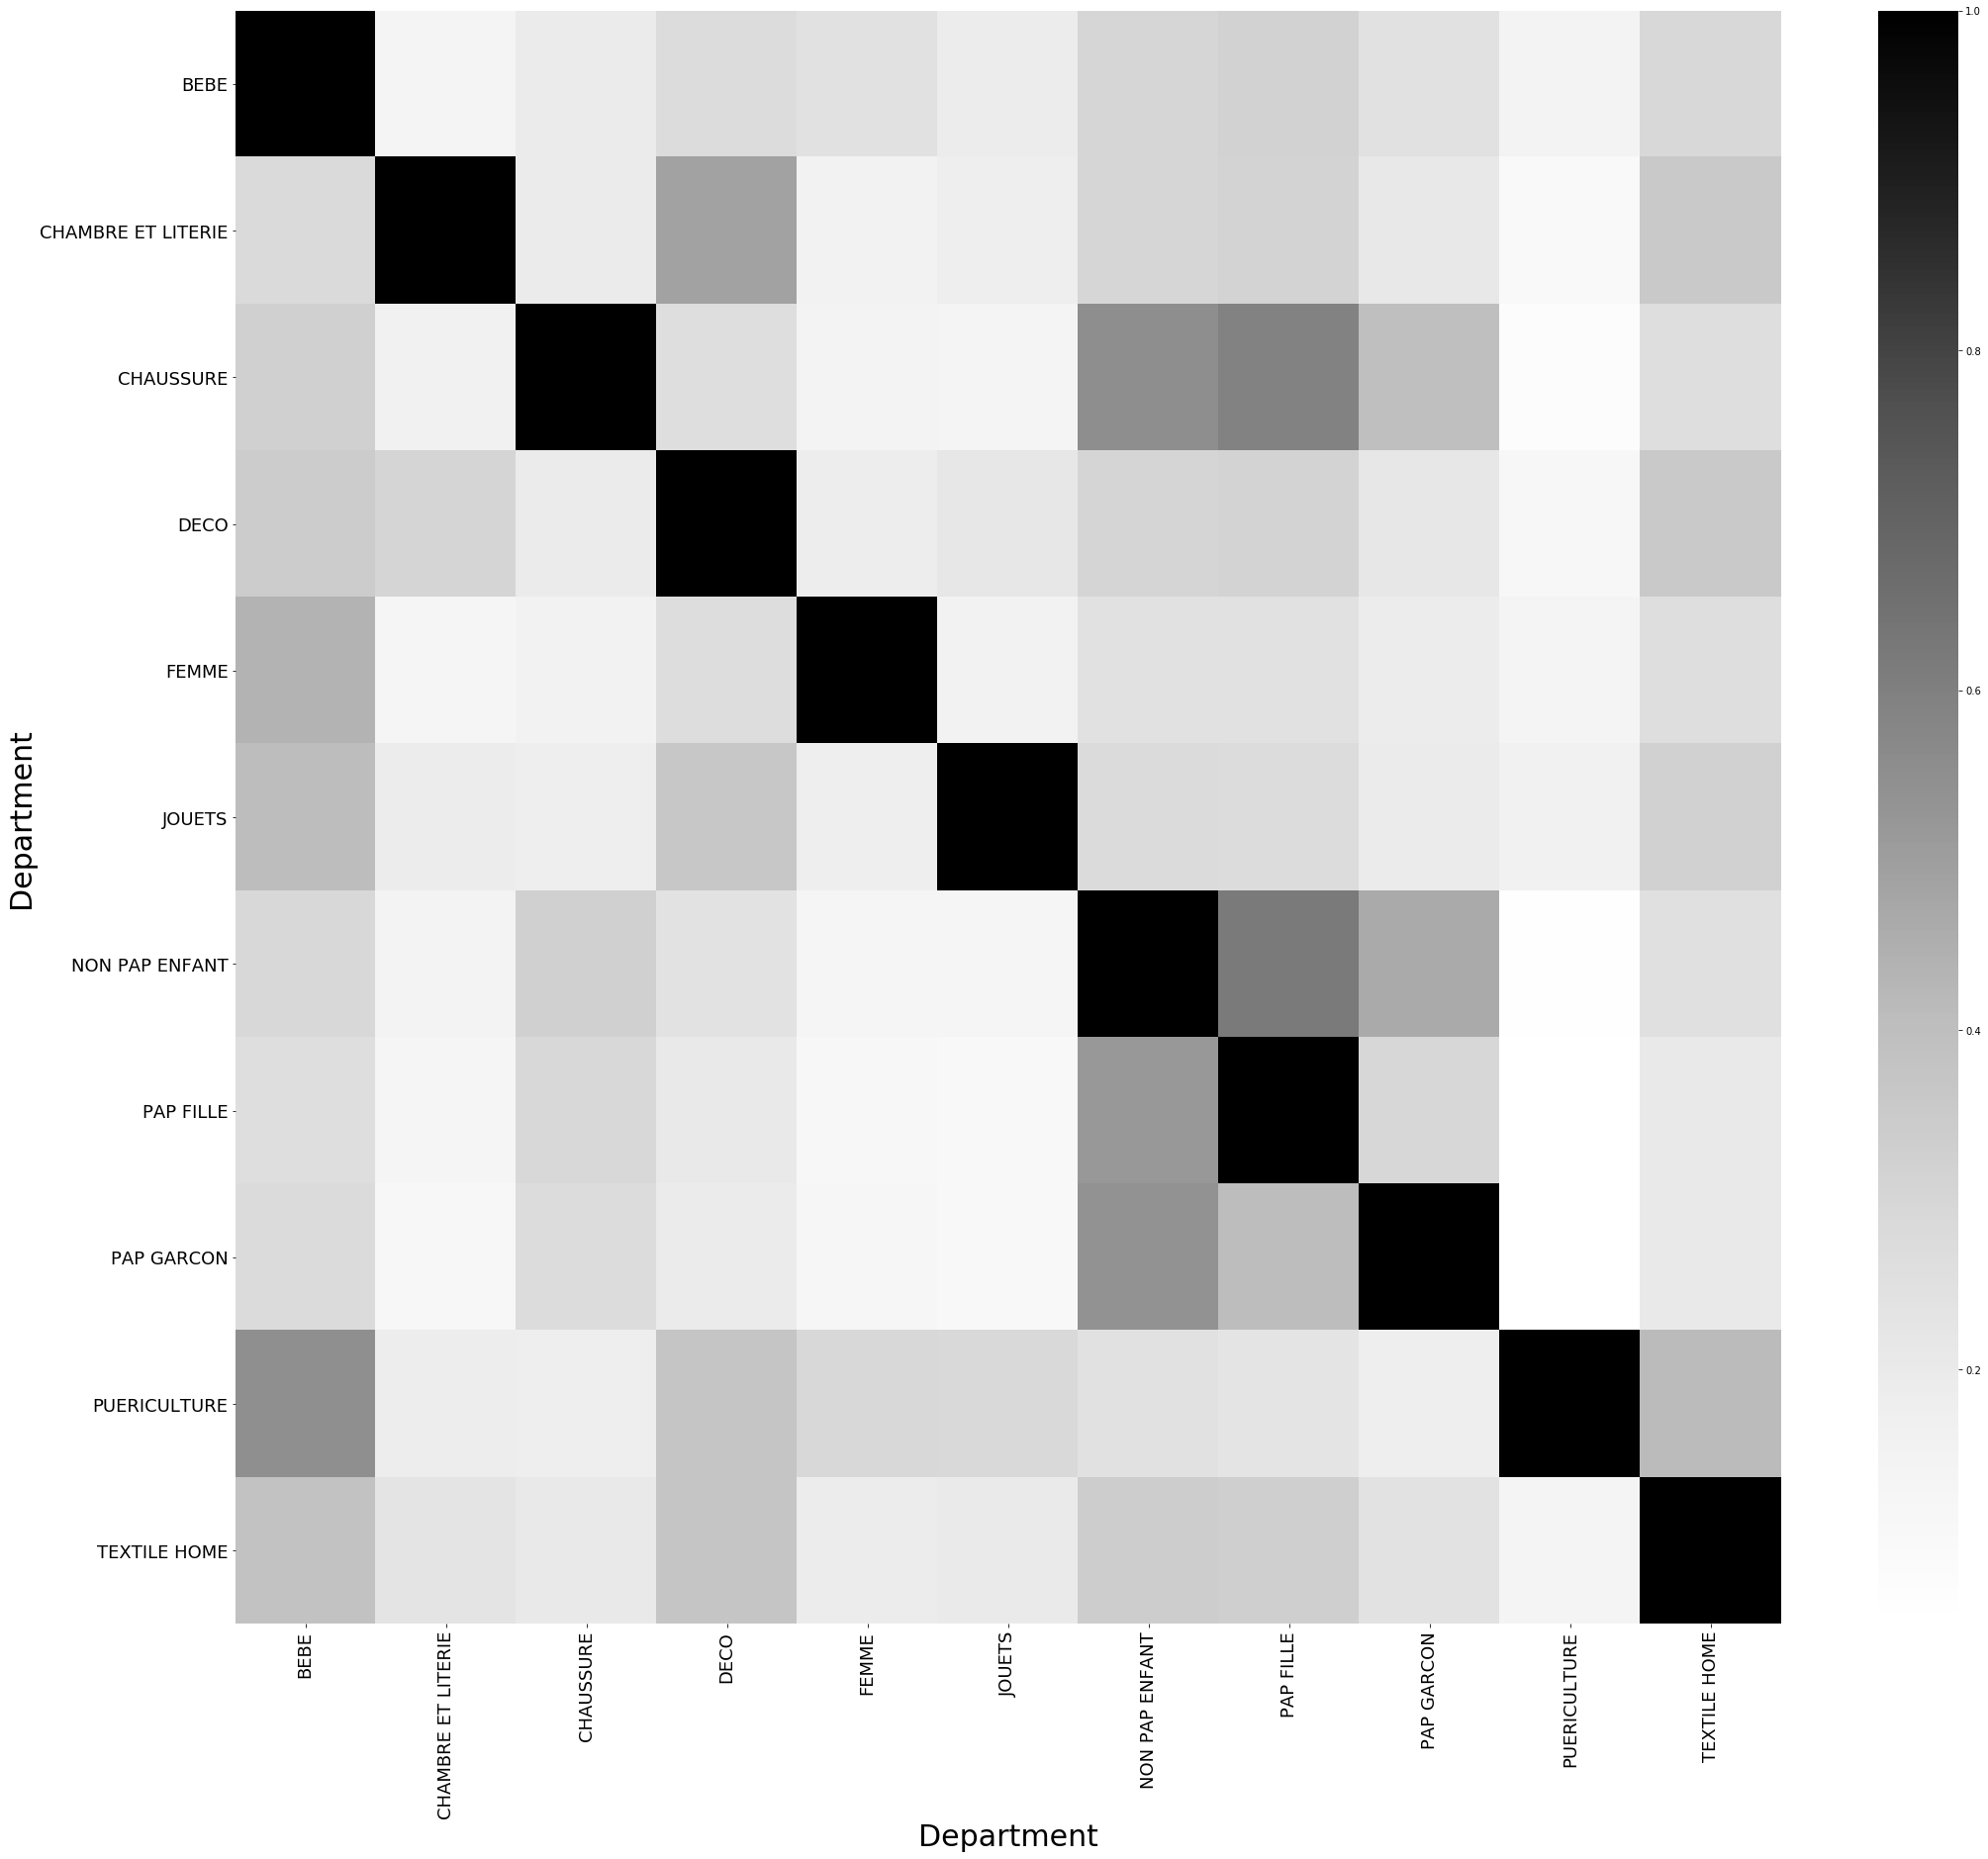

In [34]:
fig,ax = plt.subplots(figsize=(35,30))
sns.heatmap(total, annot=False, cmap="Greys")
ax.set_xlabel('Department',  fontsize = 30)
ax.set_ylabel('Department',  fontsize = 30)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18, rotation =90)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18, rotation = 0)
plt.show()

<h1> Discount distribution </h1>

In [110]:
df.RABATTSATZ.describe()
hist_data = df.RABATTSATZ

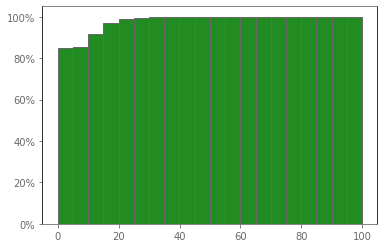

In [112]:
fig, ax = plt.subplots()
ax.hist(hist_data, bins = 20, cumulative=True, color='forestgreen',edgecolor='dimgray',weights=np.ones(len(hist_data)) / len(hist_data))

##### Set axis
# ax.set_title('Cumulative distribution of client according \n the delay between inscription and first purchase')
# ax.set_xlabel("Days to buy")
# ax.set_ylabel("Cumulative client repartition")

##### Change axis and tick colors 
ax.spines['bottom'].set_color('dimgray')
ax.spines['top'].set_color('dimgray')
ax.xaxis.label.set_color('dimgray')
ax.tick_params(axis='x', colors='dimgray')
ax.tick_params(axis='y', colors='dimgray')

ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.show()

<h1> Nombre d'univers par cohorte </h1>

In [64]:
nb_univ_fin  = pd.DataFrame(columns=[2017,2018,2019,2020,2021])
df_univ = df.loc[df.COHORT!=2016]
for year_order in df_univ.COHORT.unique():
    df_tmp = df_univ.loc[df_univ.YEAR_ORDER<=year_order]
    res_tmp = df_tmp.groupby(['COHORT','KDNR']).agg({'DEPARTEMENT': pd.Series.nunique})
    res_flat_tmp = flatten(res_tmp).groupby(['COHORT']).agg({'DEPARTEMENT': 'mean'})
    print ('Pour '+str(year_order)+' :')
    print(res_flat_tmp)
        
#     break

Pour 2017 :
        DEPARTEMENT
COHORT             
2017       1.702349
2018       1.000000
2019       4.000000
Pour 2019 :
        DEPARTEMENT
COHORT             
2017       2.208336
2018       1.875643
2019       1.541577
2020       1.000000
Pour 2018 :
        DEPARTEMENT
COHORT             
2017       2.015685
2018       1.628362
2019       1.823529
Pour 2020 :
        DEPARTEMENT
COHORT             
2017       2.384943
2018       2.095293
2019       1.828581
2020       1.608059
2021       1.615385
Pour 2021 :
        DEPARTEMENT
COHORT             
2017       2.524591
2018       2.265246
2019       2.031959
2020       1.890270
2021       1.644403


In [23]:
###Tests

In [ ]:
df_sankey_to_graph = df_sankey.loc[df_sankey.ORDER_NUMBER<=profondeur_sankey]
res_sankey = df_sankey_to_graph.groupby(['KDNR','ORDER_NUMBER']).agg({'DEPARTEMENT_CMD':'last'})
res_sankey = flatten_soft(res_sankey.unstack('ORDER_NUMBER',fill_value='CHURN').dropna(how='any'))
res_sankey.columns

for i in range(1, profondeur_sankey):
    dep_n = str('_DEPARTEMENT_CMD_'+str(i))
    dep_n_1 = str('_DEPARTEMENT_CMD_'+str(i+1))
    res_sankey_tmp = res_sankey.groupby([dep_n,dep_n_1]).agg({'KDNR':pd.Series.nunique})
    res_sankey_tmp = flatten(res_sankey_tmp)
    res_sankey_tmp = res_sankey_tmp.reset_index(inplace=False)
    
    order_n = str('Order_'+str(i))
    order_n_1 = str('Order_'+str(i+1))

    res_sankey_tmp.columns = [order_n_1,order_n,'Count']
    res_sankey_tmp = res_sankey_tmp.loc[(res_sankey_tmp[order_n]!='CHURN')]
    res_sankey_tmp[order_n]= res_sankey_tmp[order_n].apply(lambda x: str(x+'_'+str(i)))
    res_sankey_tmp[order_n_1]= res_sankey_tmp[order_n_1].apply(lambda x: str(x+'_'+str(i+1)))
    res_sankey_tmp['Count']= res_sankey_tmp['Count'].apply(lambda x: str('['+str(x)+']'))
    res_sankey_tmp = res_sankey_tmp[[order_n,'Count',order_n_1]]
    
    if zoom:
        res_sankey_tmp.to_csv(os.path.join(output_rep,str('sankey_'+str(i)+'_'+str(i+1)+'_cohort_'+str(zoom_year)+'.csv')),sep=";")
    else:
        res_sankey_tmp.to_csv(os.path.join(output_rep,str('sankey_'+str(i)+'_'+str(i+1)+'.csv')),sep=";")